In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
#!pip install category_encoders
import category_encoders as ce 

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

# Utility
import os
import time
import datetime
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
#!pip install num2words
from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from category_encoders import TargetEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # still experimental
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder, BinaryEncoder  # scikit-learn과 호환됨
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile
plt.rcParams['font.family'] = "Malgun Gothic"

#!pip install optuna
import optuna

In [2]:
train = pd.read_csv('train.csv').drop(columns = 'ID')
test = pd.read_csv('test.csv').drop(columns = 'ID')
accident = pd.read_csv('external_open/countrywide_accident.csv').drop(columns = 'ID')
cctv = pd.read_csv('external_open/CCTV_정보.csv', encoding = 'euc-kr').drop(columns = '무인교통단속카메라관리번호')
light = pd.read_csv('external_open/보안등_정보.csv', encoding = 'euc-kr')
child = pd.read_csv('external_open/어린이보호구역정보.csv', encoding = 'euc-kr')
parking = pd.read_csv('external_open/주차장_정보.csv', encoding = 'euc-kr')

In [3]:
train.사고일시 = pd.to_datetime(train['사고일시'])
test.사고일시 = pd.to_datetime(test['사고일시'])

In [4]:
train['year'] = train.사고일시.dt.year
train['month'] = train.사고일시.dt.month
train['day'] = train.사고일시.dt.day
train['hour'] = train.사고일시.dt.hour
train['weekday'] = train.사고일시.dt.day_of_week
train['day_of_year'] = pd.to_datetime(train['사고일시']).dt.day_of_year
train['week_of_year'] = pd.to_datetime(train['사고일시']).dt.isocalendar().week

test['year'] = test.사고일시.dt.year
test['month'] = test.사고일시.dt.month
test['day'] = test.사고일시.dt.day
test['hour'] = test.사고일시.dt.hour
test['weekday'] = test.사고일시.dt.day_of_week
test['day_of_year'] = pd.to_datetime(test['사고일시']).dt.day_of_year
test['week_of_year'] = pd.to_datetime(test['사고일시']).dt.isocalendar().week

In [5]:
# 시군구 columns -> gun / gu로 쪼개기
train['gun'] = train.시군구.apply(lambda x : x.split(' ')[1])
train['gu'] = train.시군구.apply(lambda x : x.split(' ')[2])
test['gun'] = test.시군구.apply(lambda x : x.split(' ')[1])
test['gu'] = test.시군구.apply(lambda x : x.split(' ')[2])

# gu column의 마지막 글자가 읍 / 면 / 동 / 가 / 로 구분
train['gu_end']=train.gu.apply(lambda x:"동" if x.endswith('동') else "읍" if x.endswith('읍') else '면' if x.endswith('면') else "가")
test['gu_end']=test.gu.apply(lambda x:"동" if x.endswith('동') else "읍" if x.endswith('읍')else '면' if x.endswith('면') else "가")

In [6]:
train.도로형태 = train.도로형태.apply(lambda x : x.split(' ')[-1]).replace('지하차도(도로)내', '지하차도').replace('미분류' ,'기타')
test.도로형태 = test.도로형태.apply(lambda x : x.split(' ')[-1]).replace('지하차도(도로)내', '지하차도').replace('미분류' ,'기타')

In [7]:
# weather_condition과 road_condition 연관지어서 기타 부분 cleansing
train.loc[train['기상상태'] == '안개', '노면상태'] = '젖음/습기'
train.loc[(train['기상상태'] == "기타") & (train['노면상태'] == "건조"), '기상상태'] = "맑음"
train.loc[(train['기상상태'] == "기타") & (train['노면상태'] == "젖음/습기"), '기상상태'] = "비"
train.loc[train['기상상태'] == '기타', '기상상태'] = '맑음'
train.loc[(train['기상상태'] == "맑음") & (train['노면상태'] == "기타"), '노면상태'] = "건조"
train.loc[(train['기상상태'] == "비") & (train['노면상태'] == "기타"), '노면상태'] = "젖음/습기"
train.loc[(train['day'].isin([4,5,20,30])) & (train['노면상태'] == "기타"), '노면상태'] = "건조"
train.loc[(train['day'].isin([21,22])) & (train['노면상태'] == "기타"), '노면상태'] = "건조"

test.loc[test['기상상태'] == '안개', '노면상태'] = '젖음/습기'
test.loc[(test['기상상태'] == "기타") & (test['노면상태'] == "건조"), '기상상태'] = "맑음"
test.loc[(test['기상상태'] == "기타") & (test['노면상태'] == "젖음/습기"), '기상상태'] = "비"
test.loc[test['기상상태'] == '기타', '기상상태'] = '맑음'
test.loc[(test['기상상태'] == "맑음") & (test['노면상태'] == "기타"), '노면상태'] = "건조"
test.loc[(test['기상상태'] == "비") & (test['노면상태'] == "기타"), '노면상태'] = "젖음/습기"

In [8]:
train.head()

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,year,month,day,hour,weekday,day_of_year,week_of_year,gun,gu,gu_end
0,2019-01-01 00:00:00,화요일,맑음,대구광역시 중구 대신동,기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,...,2019,1,1,0,1,1,1,중구,대신동,동
1,2019-01-01 00:00:00,화요일,흐림,대구광역시 달서구 감삼동,기타,건조,차대사람,보도통행중,기타,승용,...,2019,1,1,0,1,1,1,달서구,감삼동,동
2,2019-01-01 01:00:00,화요일,맑음,대구광역시 수성구 두산동,기타,건조,차대사람,차도통행중,안전운전불이행,승용,...,2019,1,1,1,1,1,1,수성구,두산동,동
3,2019-01-01 02:00:00,화요일,맑음,대구광역시 북구 복현동,기타,건조,차대차,추돌,안전운전불이행,승용,...,2019,1,1,2,1,1,1,북구,복현동,동
4,2019-01-01 04:00:00,화요일,맑음,대구광역시 동구 신암동,기타,건조,차대차,추돌,안전운전불이행,승용,...,2019,1,1,4,1,1,1,동구,신암동,동


In [9]:
test.head()

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,year,month,day,hour,weekday,day_of_year,week_of_year,gun,gu,gu_end
0,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 상동,교차로안,건조,차대사람,2022,1,1,1,5,1,52,수성구,상동,동
1,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 지산동,기타,건조,차대사람,2022,1,1,1,5,1,52,수성구,지산동,동
2,2022-01-01 04:00:00,토요일,맑음,대구광역시 수성구 수성동2가,교차로안,건조,차대차,2022,1,1,4,5,1,52,수성구,수성동2가,가
3,2022-01-01 04:00:00,토요일,맑음,대구광역시 수성구 신매동,기타,건조,차대차,2022,1,1,4,5,1,52,수성구,신매동,동
4,2022-01-01 06:00:00,토요일,맑음,대구광역시 달서구 감삼동,교차로안,건조,차대차,2022,1,1,6,5,1,52,달서구,감삼동,동


---
# CCTV 데이터 훑어보기

In [61]:
cctv.head()

,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.838857,128.575418,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.0,2010.0
1,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.844653,128.604619,효성백년가약,4,0,NaN,NaN,99.0,2013.0
2,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,대구광역시 남구 봉덕동 866-46,35.844183,128.604815,강변코오롱하늘채,4,0,NaN,NaN,99.0,2013.0
3,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,대구광역시 남구 대명동 2680-17,35.834798,128.585284,보성청록타운,4,0,NaN,NaN,99.0,2014.0
4,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,대구광역시 남구 봉덕동 1616,35.832728,128.588324,환경차고지,4,0,NaN,NaN,99.0,2014.0


In [33]:
cctv.보호구역구분 = cctv.보호구역구분.fillna(cctv.보호구역구분.mode()[0])
cctv.drop(columns = ['도로노선번호', '단속구간위치구분', '과속단속구간길이'], inplace = True)

In [36]:
cctv.위도.value_counts()

위도
35.882356    4
35.882284    4
35.731129    4
35.798606    4
35.874887    4
            ..
35.981352    1
35.859228    1
35.851650    1
35.859260    1
35.855327    1
Name: count, Length: 930, dtype: int64

In [35]:
cctv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시도명       1065 non-null   object 
 1   시군구명      1065 non-null   object 
 2   도로종류      1065 non-null   object 
 3   도로노선명     1065 non-null   object 
 4   도로노선방향    1065 non-null   int64  
 5   소재지도로명주소  905 non-null    object 
 6   소재지지번주소   1063 non-null   object 
 7   위도        1065 non-null   float64
 8   경도        1065 non-null   float64
 9   설치장소      1065 non-null   object 
 10  단속구분      1065 non-null   int64  
 11  제한속도      1065 non-null   int64  
 12  보호구역구분    1065 non-null   float64
 13  설치연도      1065 non-null   float64
dtypes: float64(4), int64(3), object(7)
memory usage: 116.6+ KB


In [76]:
child.head()

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),대구광역시 남구 대명동 1709,35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),대구광역시 남구 이천동 477,35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),대구광역시 남구 대명동 3050,35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,대구광역시 남구 대명동 531-1,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,대구광역시 남구 대명동 960,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23


In [77]:
child.보호구역도로폭.fillna(child.보호구역도로폭.mode()[0], inplace = True)
child.CCTV설치대수.fillna(child.CCTV설치대수.mean(), inplace = True)

In [81]:
child.보호구역도로폭 = child.보호구역도로폭.apply(lambda x : str(x).split('~')[0]).apply(lambda x : str(x).split('.')[0]).astype('int64')

In [ ]:
child.

In [83]:
child.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시설종류      640 non-null    object 
 1   대상시설명     640 non-null    object 
 2   소재지도로명주소  640 non-null    object 
 3   소재지지번주소   555 non-null    object 
 4   위도        640 non-null    float64
 5   경도        640 non-null    float64
 6   관리기관명     640 non-null    object 
 7   관할경찰서명    640 non-null    object 
 8   CCTV설치여부  640 non-null    object 
 9   CCTV설치대수  640 non-null    float64
 10  보호구역도로폭   640 non-null    int64  
 11  데이터기준일자   640 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 60.1+ KB


---
# 월별 ECLO 시각화

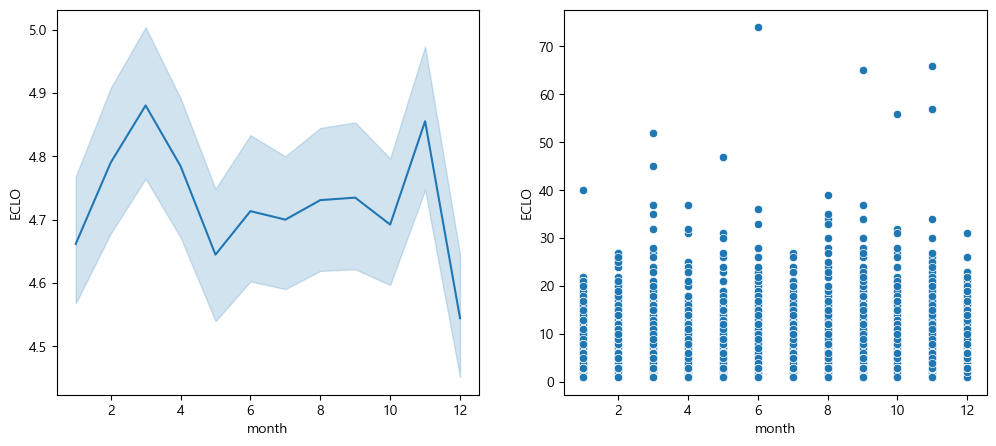

In [10]:
# 3월과 11월의 평균이 가장 높고 상대적으로 12월, 1월, 5월이 낮다
# 이상치도 봐야할 필요가 있을 듯
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data = train, x = 'month', y = 'ECLO', ax = ax1)
sns.scatterplot(data = train, x = 'month', y = 'ECLO', ax = ax2)
plt.show()

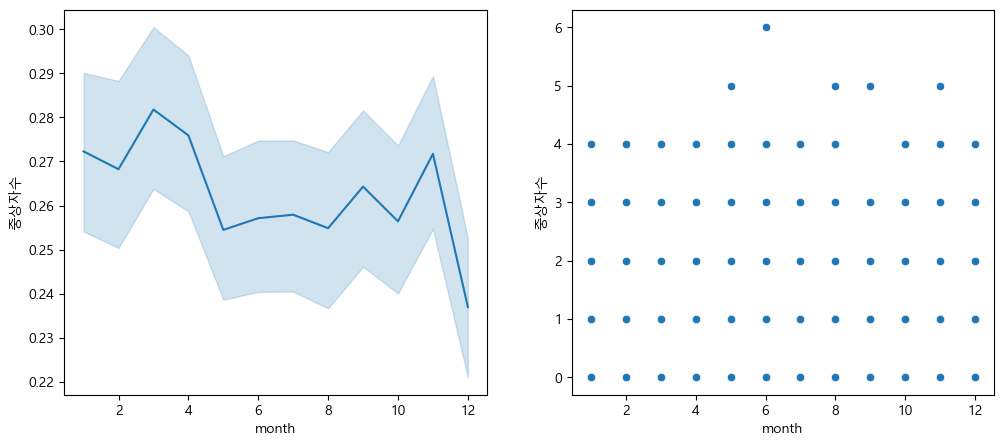

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data = train, x = 'month', y = '경상자수', ax = ax1)
sns.scatterplot(data = train, x = 'month', y = '경상자수', ax = ax2)
plt.show()

In [29]:
train['가해운전자 연령'].value_counts().sort_values().head(20)

가해운전자 연령
5세         1
4세         1
98세 이상     1
90세 이상     1
90세        2
8세         5
88세        9
89세        9
7세         9
9세        14
10세       17
87세       18
11세       23
86세       26
12세       27
13세       30
85세       32
84세       48
14세       51
83세       54
Name: count, dtype: int64

In [34]:
train.loc[train['가해운전자 연령'] == "13세"].iloc[:,:22]

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
596,2019-01-19 13:00:00,토요일,맑음,대구광역시 북구 국우동,기타,건조,차대차,기타,안전운전불이행,자전거,...,상해없음,이륜,남,29세,경상,0,0,1,0,3
3465,2019-04-07 22:00:00,일요일,맑음,대구광역시 달서구 용산동,기타,건조,차대차,측면충돌,안전운전불이행,이륜,...,상해없음,승용,남,29세,경상,0,0,2,0,6
5424,2019-05-24 21:00:00,금요일,맑음,대구광역시 서구 비산동,기타,건조,차대차,측면충돌,안전운전불이행,자전거,...,중상,승용,여,46세,상해없음,0,1,0,0,5
5876,2019-06-04 19:00:00,화요일,맑음,대구광역시 서구 평리동,교차로안,건조,차대차,측면충돌,안전운전불이행,자전거,...,부상신고,승용,남,61세,상해없음,0,0,0,1,1
9924,2019-09-17 07:00:00,화요일,맑음,대구광역시 남구 봉덕동,교차로안,건조,차대차,측면충돌,중앙선침범,자전거,...,경상,승용,남,71세,상해없음,0,0,1,0,3
11100,2019-10-12 17:00:00,토요일,맑음,대구광역시 달서구 송현동,기타,건조,차대차,추돌,안전운전불이행,자전거,...,부상신고,기타불명,기타불명,미분류,기타불명,0,0,0,1,1
13411,2019-12-04 15:00:00,수요일,맑음,대구광역시 수성구 수성동4가,교차로부근,건조,차대차,측면충돌,안전운전불이행,자전거,...,경상,기타불명,기타불명,미분류,기타불명,0,0,1,0,3
13869,2019-12-15 13:00:00,일요일,맑음,대구광역시 달서구 대천동,교차로부근,건조,차대차,측면충돌,안전운전불이행,자전거,...,부상신고,승용,여,51세,상해없음,0,0,0,1,1
14289,2019-12-25 19:00:00,수요일,맑음,대구광역시 달성군 유가읍,기타,건조,차대사람,횡단중,안전운전불이행,자전거,...,상해없음,보행자,여,61세,경상,0,0,1,0,3
18839,2020-05-16 08:00:00,토요일,맑음,대구광역시 달서구 월성동,교차로안,건조,차대차,측면충돌,안전운전불이행,자전거,...,부상신고,승용,남,46세,상해없음,0,0,0,1,1


In [20]:
train.loc[train['ECLO'] > 40].iloc[:,15:22]

,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
5358,44세,상해없음,0,1,14,0,47
10155,NaN,NaN,1,2,15,0,65
10834,53세,중상,0,4,12,0,56
12632,73세,사망,1,4,9,0,57
29350,46세,경상,0,0,15,0,45
30002,37세,사망,1,4,7,1,52
32591,48세,상해없음,0,4,18,0,74
37536,22세,경상,0,0,22,0,66


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   사고일시          10963 non-null  datetime64[ns]
 1   요일            10963 non-null  object        
 2   기상상태          10963 non-null  object        
 3   시군구           10963 non-null  object        
 4   도로형태          10963 non-null  object        
 5   노면상태          10963 non-null  object        
 6   사고유형          10963 non-null  object        
 7   year          10963 non-null  int32         
 8   month         10963 non-null  int32         
 9   day           10963 non-null  int32         
 10  hour          10963 non-null  int32         
 11  weekday       10963 non-null  int32         
 12  day_of_year   10963 non-null  int32         
 13  week_of_year  10963 non-null  UInt32        
 14  gun           10963 non-null  object        
 15  gu            10963 non-null  object

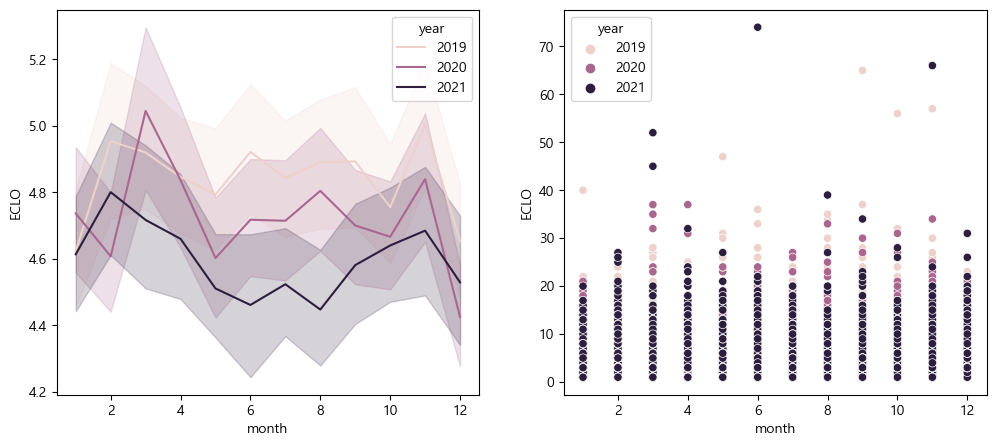

In [37]:
# 왼쪽 그래프를 보면 다 그렇진 않지만 대부분 연도가 갈수록 줄어드는 ECLO가 줄어드는 추세 --> CCTV가 많이 생겨서???
# 오른쪽 그래프를 보면 이상치는 주로 2019년과 2021년 --> 어떤 사고가 있었는지 조사할 필요가 있을 듯
# 2019년 1월, 5월, 9월, 10월, 11월
# 2021년 3월, 6월, 11월
# 2021 6월 4일 14시 --> 달서로 버스 추돌사고 --> 경상자수가 많음, 8명 병원이송 등
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data = train, x = 'month', y = 'ECLO', hue = 'year', ax = ax1)
sns.scatterplot(data = train, x = 'month', y = 'ECLO', hue = 'year', ax = ax2)
plt.show()

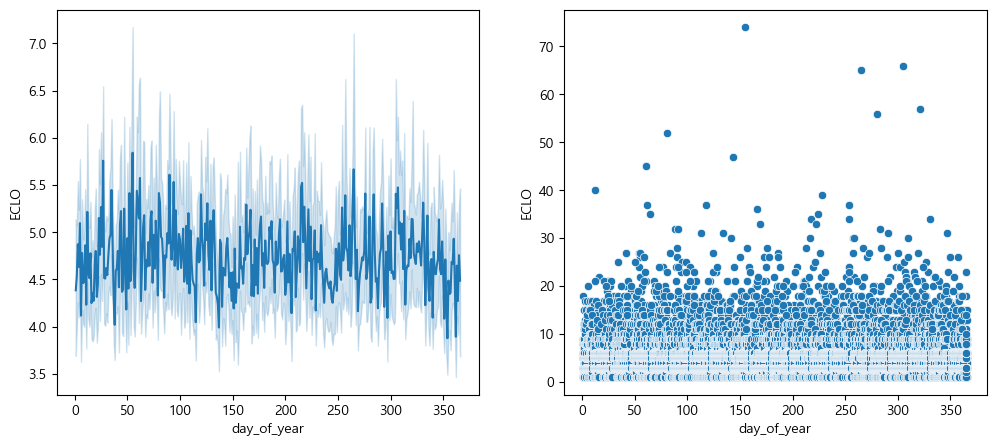

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data = train, x = 'day_of_year', y = 'ECLO', ax = ax1)
sns.scatterplot(data = train, x = 'day_of_year', y = 'ECLO', ax = ax2)
plt.show()

---
# 요일별 ECLO 시각화

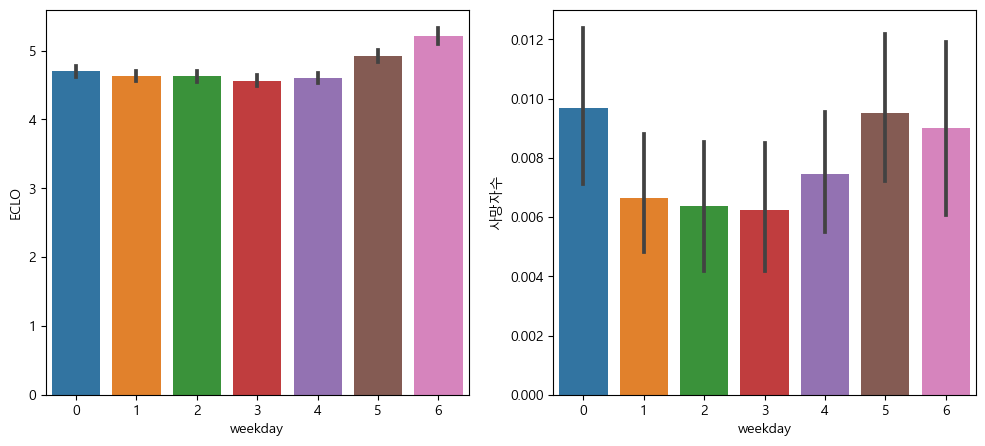

In [51]:
# 주말에 ECLO가 높고 일요일이 가장 높음
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data = train, x = 'weekday', y = 'ECLO', ax = ax1) # 요일별 ECLO
sns.barplot(data = train, x = 'weekday', y = '사망자수',ax = ax2) # 요일별 경상자수
plt.show()

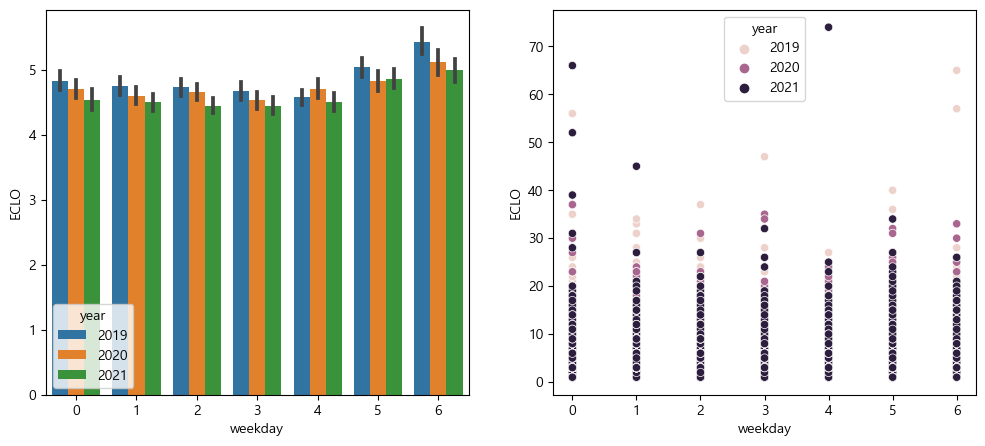

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data = train, x = 'weekday', y = 'ECLO', hue = 'year', ax = ax1)
sns.scatterplot(data = train, x = 'weekday', y = 'ECLO', hue = 'year', ax = ax2)
plt.show()

---
# 시군구별 ECLO 시각화

In [72]:
train.head()

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,year,month,day,hour,day_of_year,week_of_year,weekday,gun,gu,gu_end
0,2019-01-01 00:00:00,화요일,맑음,대구광역시 중구 대신동,기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,...,2019,1,1,0,1,1,1,중구,대신동,동
1,2019-01-01 00:00:00,화요일,흐림,대구광역시 달서구 감삼동,기타,건조,차대사람,보도통행중,기타,승용,...,2019,1,1,0,1,1,1,달서구,감삼동,동
2,2019-01-01 01:00:00,화요일,맑음,대구광역시 수성구 두산동,기타,건조,차대사람,차도통행중,안전운전불이행,승용,...,2019,1,1,1,1,1,1,수성구,두산동,동
3,2019-01-01 02:00:00,화요일,맑음,대구광역시 북구 복현동,기타,건조,차대차,추돌,안전운전불이행,승용,...,2019,1,1,2,1,1,1,북구,복현동,동
4,2019-01-01 04:00:00,화요일,맑음,대구광역시 동구 신암동,기타,건조,차대차,추돌,안전운전불이행,승용,...,2019,1,1,4,1,1,1,동구,신암동,동


In [78]:
cat_col = ['기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', 'gun', 'gu_end']

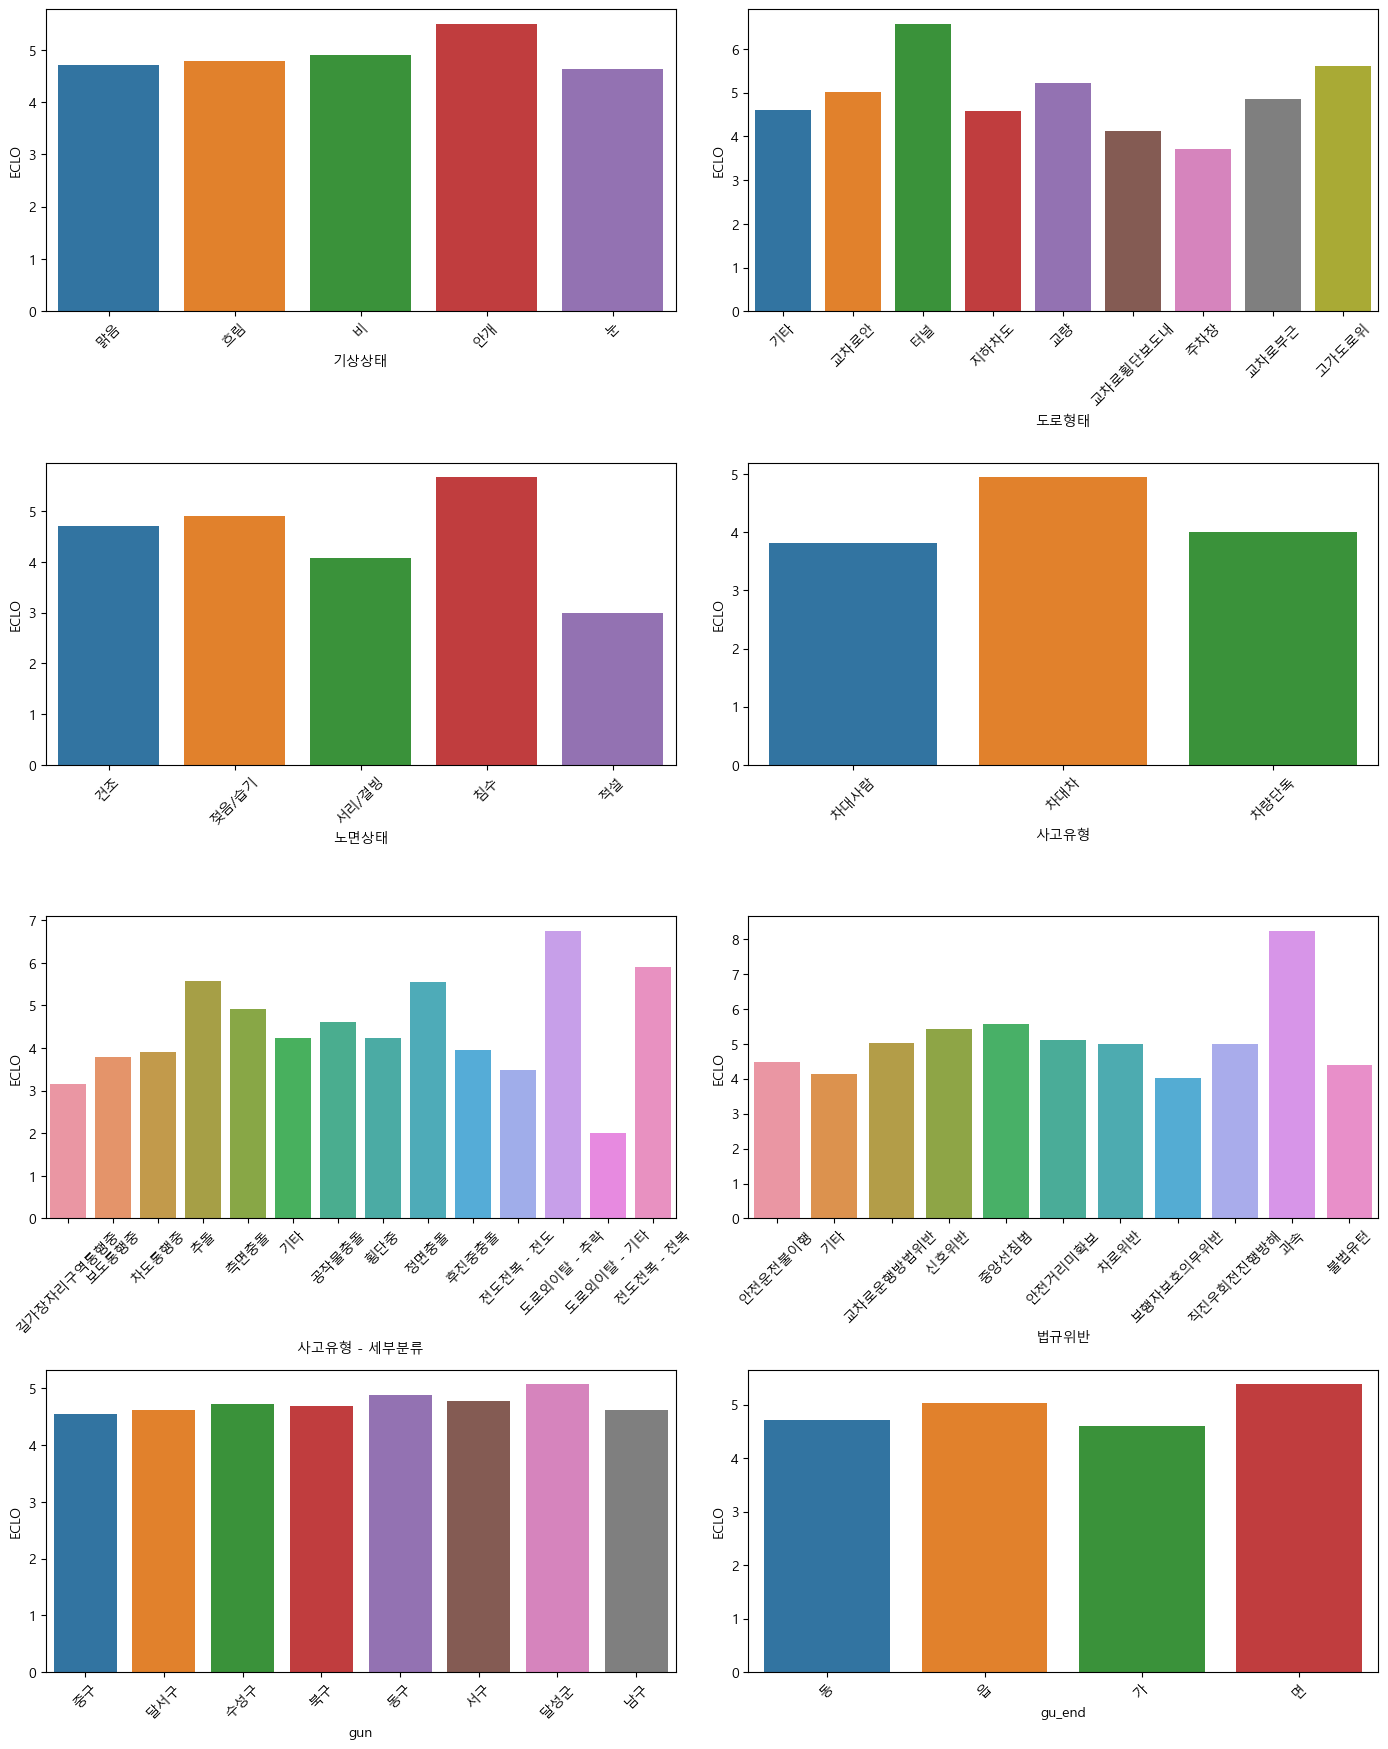

In [81]:
i = 0 
plt.figure(figsize=(14,26))
for col in cat_col:
    i += 1
    plt.subplot(6,2,i)
    sns.barplot(x=train[col], y=train['ECLO'],ci=None)
    plt.xticks(rotation=45)
plt.tight_layout()

---
# Parking Data

In [88]:
parking.head()

,주차장관리번호,주차장명,주차장구분,주차장유형,소재지도로명주소,소재지지번주소,주차구획수,급지구분,부제시행구분,운영요일,...,추가단위시간,추가단위요금,1일주차권요금적용시간,1일주차권요금,월정기권요금,결제방법,특기사항,위도,경도,데이터기준일자
0,153-2-000001,봉덕공영주차장,공영,노외,대구광역시 남구 중앙대로22길 199,대구광역시 남구 봉덕동 1002-69,62,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842206,128.601725,2020-01-01
1,153-2-000002,봉삼공영주차장,공영,노외,NaN,대구광역시 남구 봉덕동 687-8,36,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842811,128.597209,2020-01-01
2,153-2-000003,대명2동공영주차장,공영,노외,대구광역시 남구 중앙대로45길 57,대구광역시 남구 대명동 1803-10,31,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,40000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.855011,128.589359,2020-01-01
3,153-2-000004,고산골공영주차장,공영,노외,대구광역시 남구 용두2길 43,대구광역시 남구 봉덕동 1256,88,2,미시행,평일+토요일+공휴일,...,10.0,100.0,210.0,2000.0,20000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.830066,128.603443,2020-01-01
4,153-2-000005,봉덕시장공영주차장,공영,노외,대구광역시 남구 봉덕로25길 6,대구광역시 남구 봉덕동 976-5,32,1,미시행,평일+토요일+공휴일,...,10.0,200.0,160.0,3000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.844925,128.602667,2020-01-01


In [89]:
parking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   주차장관리번호      871 non-null    object 
 1   주차장명         871 non-null    object 
 2   주차장구분        871 non-null    object 
 3   주차장유형        871 non-null    object 
 4   소재지도로명주소     674 non-null    object 
 5   소재지지번주소      775 non-null    object 
 6   주차구획수        871 non-null    int64  
 7   급지구분         871 non-null    int64  
 8   부제시행구분       871 non-null    object 
 9   운영요일         871 non-null    object 
 10  평일운영시작시각     871 non-null    object 
 11  평일운영종료시각     871 non-null    object 
 12  토요일운영시작시각    871 non-null    object 
 13  토요일운영종료시각    871 non-null    object 
 14  공휴일운영시작시각    871 non-null    object 
 15  공휴일운영종료시각    871 non-null    object 
 16  요금정보         871 non-null    object 
 17  주차기본시간       871 non-null    int64  
 18  주차기본요금       871 non-null    int64  
 19  추가단위시간  

In [83]:
parking.주차장명.value_counts()

주차장명
대구유료주차장          3
삼덕유료주차장          3
덕영유료주차장          3
와룡로10길인근         3
한일유료주차장          3
                ..
도평동 제2공영주차장      1
반야월공영주차장         1
미대동 공영주차장        1
1·2              1
계명대학교 동산병원주차장    1
Name: count, Length: 834, dtype: int64

In [87]:
parking

,주차장관리번호,주차장명,주차장구분,주차장유형,소재지도로명주소,소재지지번주소,주차구획수,급지구분,부제시행구분,운영요일,...,추가단위시간,추가단위요금,1일주차권요금적용시간,1일주차권요금,월정기권요금,결제방법,특기사항,위도,경도,데이터기준일자
0,153-2-000001,봉덕공영주차장,공영,노외,대구광역시 남구 중앙대로22길 199,대구광역시 남구 봉덕동 1002-69,62,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842206,128.601725,2020-01-01
1,153-2-000002,봉삼공영주차장,공영,노외,NaN,대구광역시 남구 봉덕동 687-8,36,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842811,128.597209,2020-01-01
2,153-2-000003,대명2동공영주차장,공영,노외,대구광역시 남구 중앙대로45길 57,대구광역시 남구 대명동 1803-10,31,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,40000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.855011,128.589359,2020-01-01
3,153-2-000004,고산골공영주차장,공영,노외,대구광역시 남구 용두2길 43,대구광역시 남구 봉덕동 1256,88,2,미시행,평일+토요일+공휴일,...,10.0,100.0,210.0,2000.0,20000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.830066,128.603443,2020-01-01
4,153-2-000005,봉덕시장공영주차장,공영,노외,대구광역시 남구 봉덕로25길 6,대구광역시 남구 봉덕동 976-5,32,1,미시행,평일+토요일+공휴일,...,10.0,200.0,160.0,3000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.844925,128.602667,2020-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,150-4-000142,아세아유료주차장,민영,노외,대구광역시 중구 동덕로38길 14,대구광역시 중구 동인동1가 330-8,36,1,미시행,평일+토요일,...,15.0,500.0,NaN,NaN,NaN,현금,NaN,35.871292,128.605331,2019-06-21
867,150-4-000143,코끼리유료주차장,민영,노외,대구광역시 중구 달성로22길 88,대구광역시 중구 수창동 95-1,15,1,미시행,평일+토요일,...,NaN,NaN,NaN,NaN,NaN,현금,"1시간 2,000원",35.874460,128.586939,2019-06-21
868,150-4-000144,반월당유료주차장,민영,노외,대구광역시 중구 달구벌대로 2115-3(봉산동),대구광역시 중구 봉산동 38-2,20,1,미시행,평일+토요일,...,30.0,1000.0,NaN,NaN,NaN,현금,NaN,35.865434,128.595350,2019-06-21
869,150-4-000145,동덕유료주차장,민영,노외,대구광역시 중구 동덕로 114-11,대구광역시 중구 삼덕동2가 246,40,1,미시행,평일+토요일,...,60.0,1000.0,NaN,NaN,NaN,현금,NaN,35.864850,128.603883,2019-06-21
